<a href="https://colab.research.google.com/github/binhdtcs/datamining_bank/blob/main/253.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install torch torchvision torchaudio
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv
!pip install ogb networkx matplotlib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547369 sha256=913bcafc7d086989121a3957076cb6f39551fd232b782de7054b36180b148d19
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1127935 sha256=f95b8331e8cc70e778324a73c3f93325e14539b74bfd1a6fbece39e388d2bc33
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
  Created wheel for tor

In [34]:
!pip install torch-geometric


**Tải và tiền xử lý dữ liệu Cora**

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt

# Tải dữ liệu Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Trích xuất dữ liệu
data = dataset[0]
print("Số nút:", data.num_nodes)
print("Số cạnh:", data.num_edges)
print("Số nhãn:", dataset.num_classes)
print("Dữ liệu đầu vào:", data)



Processing...


Số nút: 2708
Số cạnh: 10556
Số nhãn: 7
Dữ liệu đầu vào: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


**Biểu diễn đồ thị bằng NetworkX**

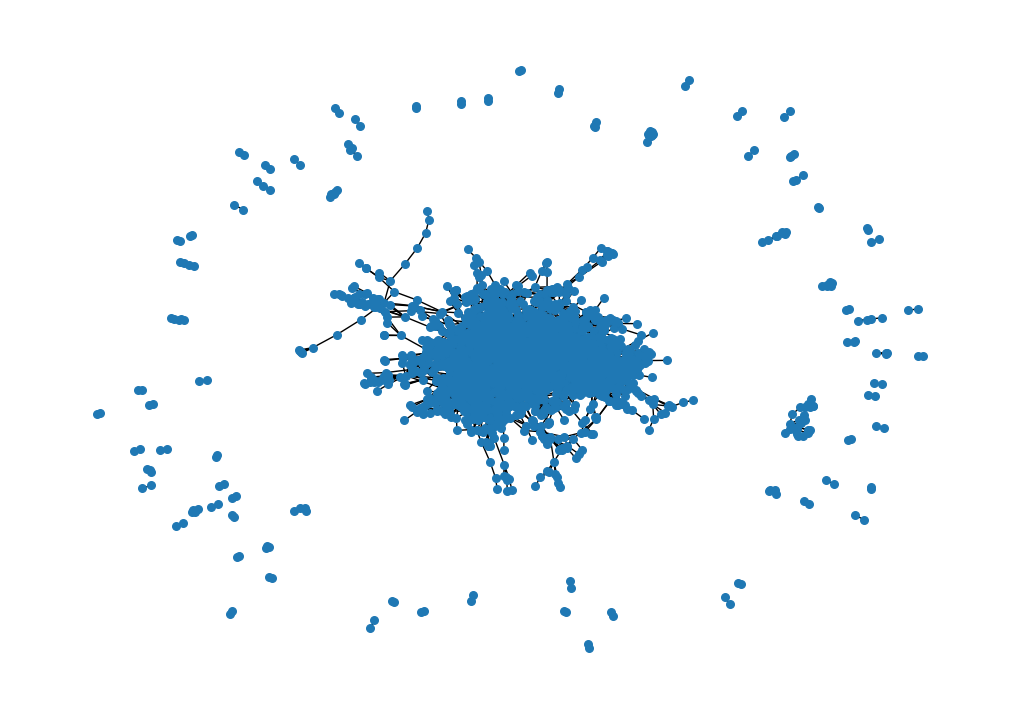

In [30]:
def visualize_graph(data):
    G = nx.Graph()
    edge_index = data.edge_index.numpy()

    for i in range(edge_index.shape[1]):
        G.add_edge(int(edge_index[0, i]), int(edge_index[1, i]))

    plt.figure(figsize=(10, 7))
    nx.draw(G, node_size=30, with_labels=False)
    plt.show()

visualize_graph(data)




**Xây dựng mô hình GCN**

In [31]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(dataset.num_node_features, dataset.num_classes)
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


**Huấn luyện mô hình**

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')



Epoch 0, Loss: 1.9492
Epoch 20, Loss: 0.1230
Epoch 40, Loss: 0.0162
Epoch 60, Loss: 0.0153
Epoch 80, Loss: 0.0178
Epoch 100, Loss: 0.0165
Epoch 120, Loss: 0.0146
Epoch 140, Loss: 0.0132
Epoch 160, Loss: 0.0122
Epoch 180, Loss: 0.0113


**Đánh giá mô hình**

In [33]:
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        print(f'Độ chính xác: {acc:.4f}')

test()



Độ chính xác: 0.8090


**GraphSAGE**

In [35]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)  # Lớp GraphSAGE
        self.conv2 = SAGEConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Khởi tạo mô hình GraphSAGE
model_sage = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer_sage = torch.optim.Adam(model_sage.parameters(), lr=0.01, weight_decay=5e-4)


**Huấn luyện và đánh giá GraphSAGE**

In [36]:
def train_sage():
    model_sage.train()
    optimizer_sage.zero_grad()
    out = model_sage(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_sage.step()
    return loss.item()

for epoch in range(200):
    loss = train_sage()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

def test_sage():
    model_sage.eval()
    with torch.no_grad():
        out = model_sage(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        print(f'GraphSAGE - Độ chính xác: {acc:.4f}')

test_sage()


Epoch 0, Loss: 1.9554
Epoch 20, Loss: 0.0019
Epoch 40, Loss: 0.0005
Epoch 60, Loss: 0.0018
Epoch 80, Loss: 0.0042
Epoch 100, Loss: 0.0048
Epoch 120, Loss: 0.0044
Epoch 140, Loss: 0.0041
Epoch 160, Loss: 0.0038
Epoch 180, Loss: 0.0036
GraphSAGE - Độ chính xác: 0.7910


**GAT**

In [37]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8)  # Lớp GAT đầu tiên
        self.conv2 = GATConv(8 * 8, num_classes, heads=1)  # Lớp GAT thứ hai

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Hàm kích hoạt ELU
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Khởi tạo mô hình GAT
model_gat = GAT(dataset.num_node_features, dataset.num_classes)
optimizer_gat = torch.optim.Adam(model_gat.parameters(), lr=0.005, weight_decay=5e-4)


**Huấn luyện và đánh giá GAT**

In [38]:
def train_gat():
    model_gat.train()
    optimizer_gat.zero_grad()
    out = model_gat(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gat.step()
    return loss.item()

for epoch in range(200):
    loss = train_gat()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

def test_gat():
    model_gat.eval()
    with torch.no_grad():
        out = model_gat(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        print(f'GAT - Độ chính xác: {acc:.4f}')

test_gat()


Epoch 0, Loss: 1.9460
Epoch 20, Loss: 0.0218
Epoch 40, Loss: 0.0030
Epoch 60, Loss: 0.0053
Epoch 80, Loss: 0.0078
Epoch 100, Loss: 0.0073
Epoch 120, Loss: 0.0066
Epoch 140, Loss: 0.0060
Epoch 160, Loss: 0.0055
Epoch 180, Loss: 0.0051
GAT - Độ chính xác: 0.8040
